In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [9]:
## Loading the dataset
df = pd.read_csv("Automobile Insurance Dataset.csv", delimiter = ";", quotechar = '"')

In [10]:
##Checking the dataset
print(df.head())

    NAIC                             Company_Name  Ratio  Upheld_Complaints  \
0  32786  Progressive Specialty Insurance Company    0.0                  0   
1  19976           Amica Mutual Insurance Company    0.0                  0   
2  25453  Nationwide Insurance Company of America    0.0                  0   
3  15024       Preferred Mutual Insurance Company    0.0                  0   
4  10052         Chubb National Insurance Company    0.0                  0   

   Question_of_Fact_Complaints  Not_Upheld_Complaints  Total_Complaints  \
0                           17                     29                46   
1                            9                      8                17   
2                            9                      4                13   
3                            3                      2                 5   
4                            1                      2                 3   

   Premiums_Written  Ranking  Filing_Year  FIELD11  FIELD12  
0           

In [12]:
## Ensuring numeric values for trend analysis
df["Filing_Year"] = pd.to_numeric(df["Filing_Year"], errors = "coerce")
df["Upheld_Complaints"] = pd.to_numeric(df["Upheld_Complaints"], errors = "coerce")
df["Question_of_Fact_Complaints"] = pd.to_numeric(df["Question_of_Fact_Complaints"], errors = "coerce")
df["Not_Upheld_Complaints"] = pd.to_numeric(df["Not_Upheld_Complaints"], errors = "coerce")
df["Premiums_Written"] = pd.to_numeric(df["Premiums_Written"], errors = "coerce")

In [13]:
##Checking Null Values
print(df.isna().sum())

NAIC                              0
Company_Name                      0
Ratio                             0
Upheld_Complaints                 0
Question_of_Fact_Complaints       0
Not_Upheld_Complaints             0
Total_Complaints                  0
Premiums_Written                  0
Ranking                           0
Filing_Year                       0
FIELD11                        1358
FIELD12                        1358
dtype: int64


In [14]:
#Calculating Valid_Claims and Complaints_Ratio_Valid
df["Valid_Claims"] = df.get("Valid_Claims", df["Upheld_Complaints"].fillna(0) + df["Question_of_Fact_Complaints"].fillna(0))
df["Complaints_Ratio_Valid"] = np.where(df["Premiums_Written"] == 0, np.nan, df["Valid_Claims"] / df["Premiums_Written"])

In [17]:
# Step 1: calculate slope per company based on Complaints Ratio
companies = []
slopes = []

for name, group in df.groupby("Company_Name"):
    if len(group) > 1:
        slope = np.polyfit(group["Filing_Year"], group["Complaints_Ratio_Valid"], 1)[0]
    else:
        slope = np.nan
    companies.append(name)
    slopes.append(slope)

# Step 2: create DataFrame with complaint ratio slopes
slope_df = pd.DataFrame({
    "Company_Name": companies,
    "slope_per_year": slopes
})

In [18]:
##Trend Analysis for companies complaint ratio
trend = df.groupby(["Company_Name", "Filing_Year"], as_index=False)["Complaints_Ratio_Valid"].mean()

# Step 3: getting top 5 companies by total Complaints Ratio 
top_companies = df.groupby("Company_Name")["Complaints_Ratio_Valid"].sum().nlargest(5).index

# Step 4: filtering slope_df for top companies
trend_summary = slope_df[slope_df["Company_Name"].isin(top_companies)].copy()

# Step 5: adding trend_class
trend_summary["trend_class"] = trend_summary["slope_per_year"].apply(
    lambda s: "improving" if pd.notna(s) and s > 0 
              else ("declining" if pd.notna(s) and s < 0 
                    else "no trend")
)

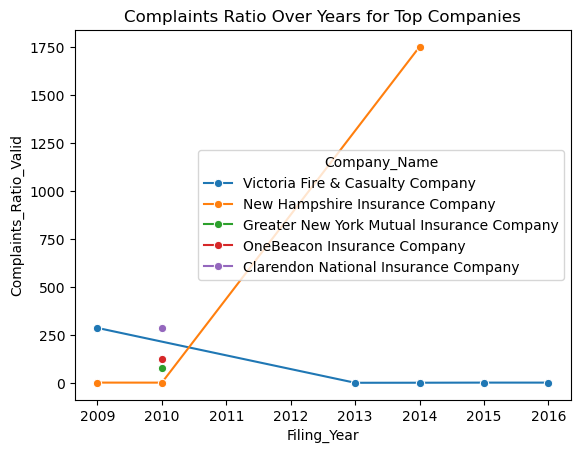

In [19]:
##Checking the trend analysis for Complaints ration over years for top companies
sns.lineplot(data=df[df['Company_Name'].isin(top_companies)], 
             x='Filing_Year', y='Complaints_Ratio_Valid', hue='Company_Name', marker='o')
plt.title("Complaints Ratio Over Years for Top Companies")
plt.show()

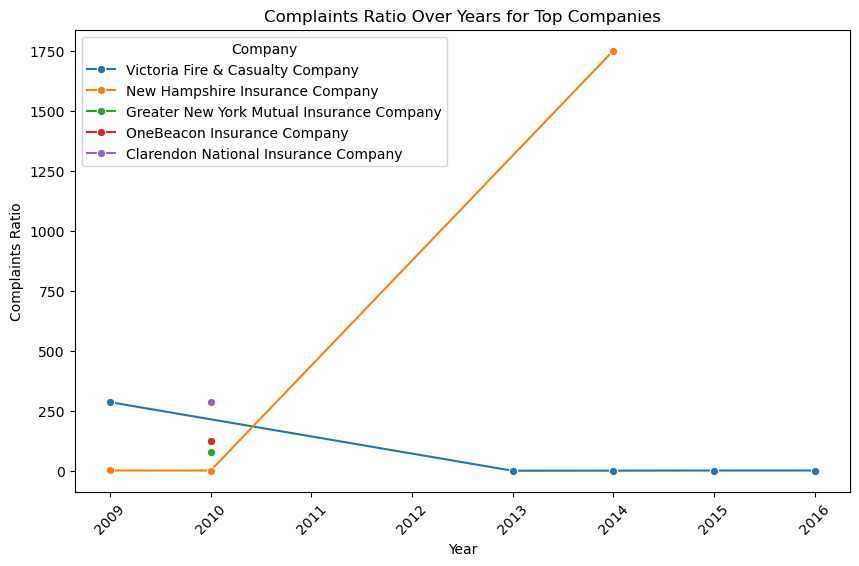

In [21]:
# Step 4: trend strength = magnitude of change in complaints per year
slope_df['trend_strength'] = slope_df['slope_per_year'].abs()
top_companies = df.groupby("Company_Name")["Complaints_Ratio_Valid"].sum().nlargest(5).index
trend_summary = slope_df[slope_df["Company_Name"].isin(top_companies)].copy()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df[df['Company_Name'].isin(top_companies)],
    x='Filing_Year',
    y='Complaints_Ratio_Valid',
    hue='Company_Name',
    marker='o'
)
plt.title("Complaints Ratio Over Years for Top Companies")
plt.xlabel("Year")
plt.ylabel("Complaints Ratio")
plt.xticks(rotation=45)
plt.legend(title="Company")
plt.show()

In [ ]:
### Key Insights###
# New Hampshire Insurance Company shows the highest trend strength by 2014, indicating rapid worsening in complaint ratios over time.

# Victoria Fire & Casualty has a moderate but improving trend by 2016, signaling progress in reducing complaints.

# Greater New York Mutual Insurance Company & One reflects a stable/no-trend slope (≈0), suggesting limited change in customer experience.

# Interpretation: A higher trend strength indicates stronger movement (positive = improving, negative = worsening).

##Strategic Implications

# Declining Companies: Need targeted interventions in claims handling, faster response mechanisms, and proactive complaint resolution.

# Improving Companies: Should be used as benchmarks to replicate best practices across the sector.

# Regulators & Executives: Complaint trends act as a leading indicator of customer satisfaction and should be integrated into performance KPIs.